In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix
import math

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = font_manager.FontProperties(fname=font_path)
rc('font', family=fontprop.get_name())

# 1. 데이터 로드
train = pd.read_csv('/apps/study_promptengineerings/dacon/debt_risk/train.csv')
test = pd.read_csv('/apps/study_promptengineerings/dacon/debt_risk/test.csv')

# ID 매핑 저장 및 컬럼 제거
id_mapping = pd.Series(test['UID'].values, index=test.index)
train = train.drop('UID', axis=1)
test = test.drop('UID', axis=1)

# 결측치 확인
print("Train set missing values:")
print(train.isnull().sum())
print("\nTest set missing values:")
print(test.isnull().sum())


Train set missing values:
주거 형태                0
연간 소득                0
현재 직장 근속 연수          0
체납 세금 압류 횟수          0
개설된 신용계좌 수           0
신용 거래 연수             0
최대 신용한도              0
신용 문제 발생 횟수          0
마지막 연체 이후 경과 개월 수    0
개인 파산 횟수             0
대출 목적                0
대출 상환 기간             0
현재 대출 잔액             0
현재 미상환 신용액           0
월 상환 부채액             0
신용 점수                0
채무 불이행 여부            0
dtype: int64

Test set missing values:
주거 형태                0
연간 소득                0
현재 직장 근속 연수          0
체납 세금 압류 횟수          0
개설된 신용계좌 수           0
신용 거래 연수             0
최대 신용한도              0
신용 문제 발생 횟수          0
마지막 연체 이후 경과 개월 수    0
개인 파산 횟수             0
대출 목적                0
대출 상환 기간             0
현재 대출 잔액             0
현재 미상환 신용액           0
월 상환 부채액             0
신용 점수                0
dtype: int64


Training fold 1/5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2730, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341250 -> initscore=-0.657729
[LightGBM] [Info] Start training from score -0.657729
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.588746
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.586683
Training fold 2/5
[LightGBM] [Warning] Found whitespace in feature_names, replace with un

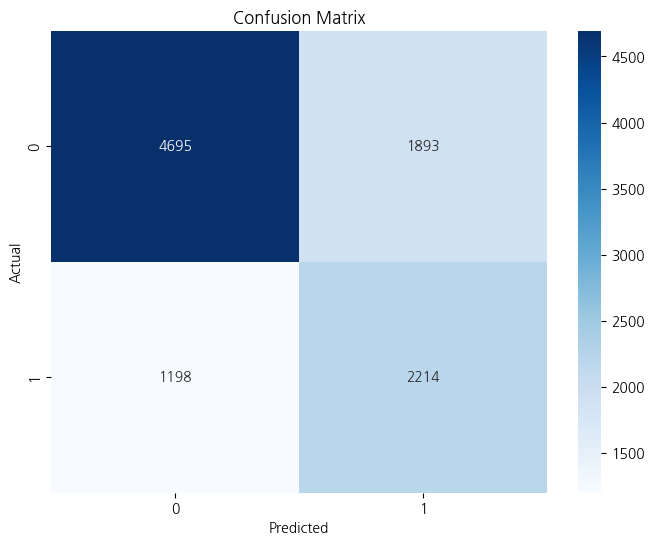

Submission file has been created successfully!


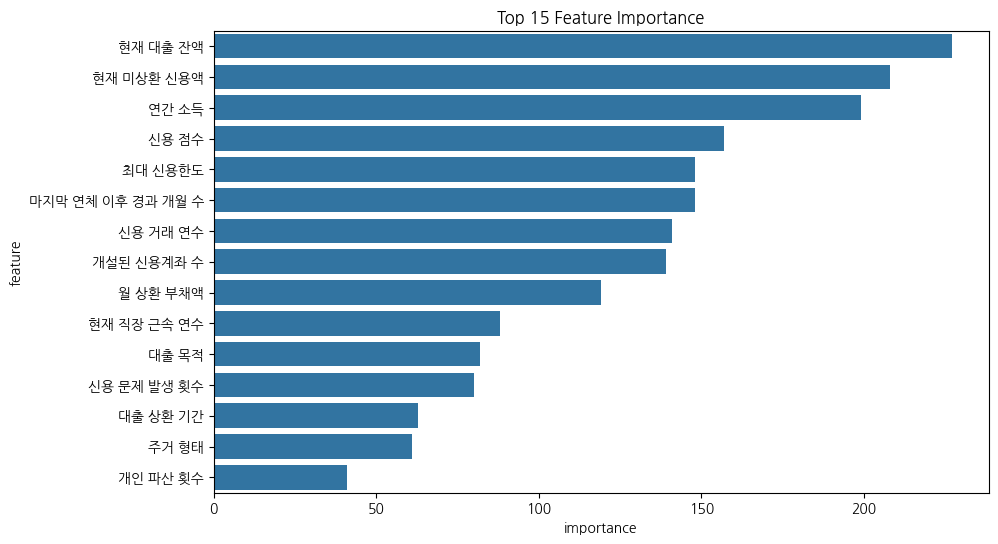

In [21]:

# 3. 피처 인코딩
# 3.1 레이블 인코딩
label_cols = ['주거 형태', '대출 목적', '대출 상환 기간', '현재 직장 근속 연수']
for col in label_cols:
    le = LabelEncoder()
    combined_data = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined_data)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# # 3.2 원-핫 인코딩
# onehot_cols = ['', '']
# onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

## 피처 이름 생성
# feature_names = []
# for col in onehot_cols:
#     unique_vals = pd.concat([train[col], test[col]]).unique()
#     feature_names.extend([f"{col}_{val}" for val in unique_vals])

# # 인코딩 적용
# train_encoded = onehot.fit_transform(train[onehot_cols])
# test_encoded = onehot.transform(test[onehot_cols])

# # 데이터프레임 결합
# train = pd.concat([
#     train.drop(columns=onehot_cols),
#     pd.DataFrame(train_encoded, index=train.index, columns=feature_names)
# ], axis=1)

# test = pd.concat([
#     test.drop(columns=onehot_cols),
#     pd.DataFrame(test_encoded, index=test.index, columns=feature_names)
# ], axis=1)

# 4. 데이터 준비
X = train.drop('채무 불이행 여부', axis=1)
y = train['채무 불이행 여부']

# 클래스 가중치 계산
class_weights = dict(zip(
    np.unique(y),
    1 / np.bincount(y) * len(y) / 2
))

# 5. 모델 학습 및 예측
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 15,
    'learning_rate': 0.05,
    'seed': 42,
    'metric': 'binary_logloss',
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'min_child_samples': 20,
    'scale_pos_weight': class_weights[1]/class_weights[0]  # 클래스 불균형 처리
}

# 교차 검증 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))

# 모델 학습
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Training fold {fold + 1}/5")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )
    
    oof_preds[val_idx] = model.predict(X_val)
    test_preds += model.predict(test) / skf.n_splits

# 6. 모델 평가
oof_preds_binary = (oof_preds > 0.5).astype(int)
f1 = f1_score(y, oof_preds_binary, average='macro')
print(f"\nOOF F1 Score: {f1:.4f}")

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, oof_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 7. 제출 파일 생성
test_preds_binary = (test_preds > 0.5).astype(int)
submission = pd.DataFrame({
    'UID': id_mapping,
    '채무 불이행 확률': test_preds_binary
})
submission.to_csv('submission.csv', index=False)
print("Submission file has been created successfully!")

# 8. 특성 중요도 시각화
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.show()